In [4]:
!pip uninstall tensorflow tensorflow-text
!pip install tensorflow==2.13.0 tensorflow-text==2.13.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.1
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [4]:
import tensorflow as tf
import tensorflow_text as tf_text

In [7]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
MODEL_PATH = '/content/drive/MyDrive/translator'
reloaded_model = tf.saved_model.load(MODEL_PATH)
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                             with_info=True,
                             as_supervised=True)
test_examples = examples['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2A22D2_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2A22D2_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2A22D2_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [23]:
BATCH_SIZE = 32
test_batches = (
    test_examples
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [27]:
from tqdm.notebook import tqdm
import numpy as np

bleu_scores = []
source_lengths = []
translated_lengths = []
target_lengths = []
translation_examples = []

total_batches = 3

with tqdm(total=total_batches, desc='Batches', position=0) as batch_pbar:
    for pt_batch, en_batch in test_batches.take(total_batches):
        batch_size = len(pt_batch)
        with tqdm(total=batch_size, desc='Sentences', position=1, leave=False) as sent_pbar:
            for pt, en in zip(pt_batch, en_batch):
                translated = reloaded_model(pt)

                source = pt.numpy().decode('utf-8')
                translation = translated.numpy().decode('utf-8')
                reference = en.numpy().decode('utf-8')
                translation_examples.append({
                    'source': source,
                    'translation': translation,
                    'reference': reference
                })

                reference_tokens = reference.split()
                translation_tokens = translation.split()
                score = sentence_bleu([reference_tokens], translation_tokens)
                bleu_scores.append(score)

                source_lengths.append(len(source.split()))
                translated_lengths.append(len(translation.split()))
                target_lengths.append(len(reference.split()))

                sent_pbar.set_postfix({'BLEU': f'{np.mean(bleu_scores):.4f}'})
                sent_pbar.update(1)

        batch_pbar.update(1)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

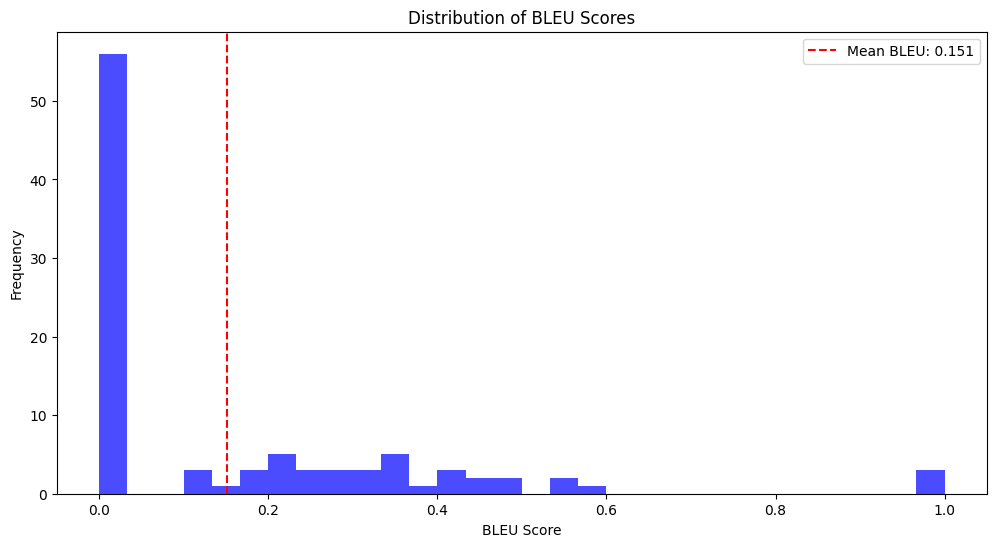

Average BLEU Score: 0.151
Median BLEU Score: 0.000
BLEU Score Std Dev: 0.227


In [28]:
plt.figure(figsize=(12, 6))
plt.hist(bleu_scores, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(bleu_scores), color='red', linestyle='--',
            label=f'Mean BLEU: {np.mean(bleu_scores):.3f}')
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Average BLEU Score: {np.mean(bleu_scores):.3f}")
print(f"Median BLEU Score: {np.median(bleu_scores):.3f}")
print(f"BLEU Score Std Dev: {np.std(bleu_scores):.3f}")

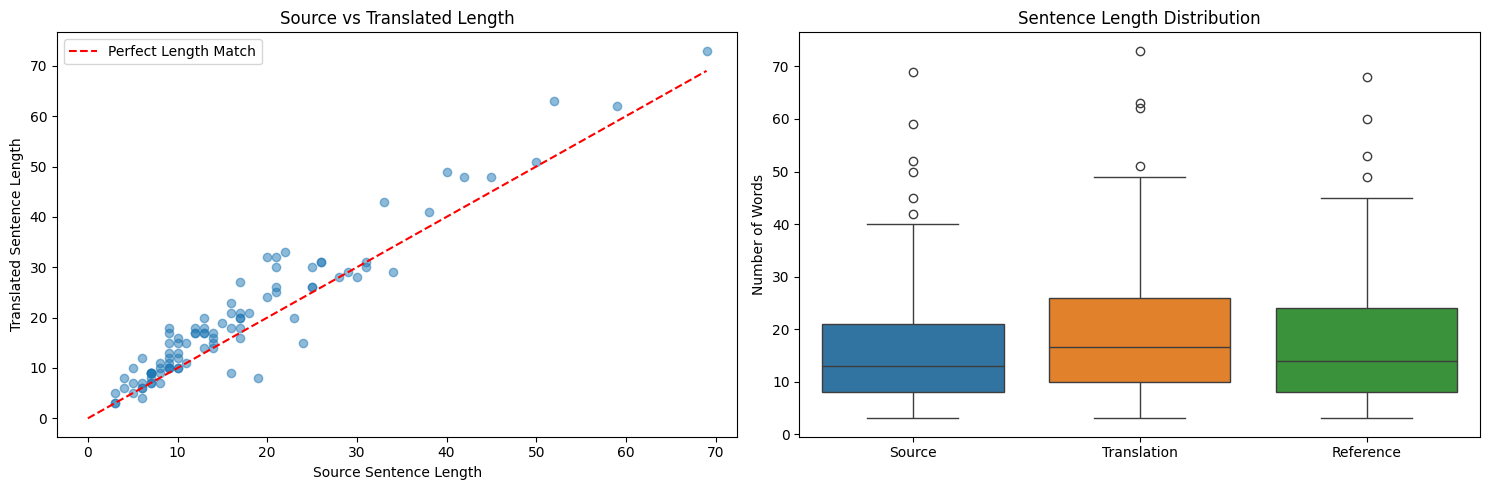

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(source_lengths, translated_lengths, alpha=0.5)
plt.plot([0, max(source_lengths)], [0, max(source_lengths)], 'r--',
         label='Perfect Length Match')
plt.xlabel('Source Sentence Length')
plt.ylabel('Translated Sentence Length')
plt.title('Source vs Translated Length')
plt.legend()

plt.subplot(1, 2, 2)
data = pd.DataFrame({
    'Source': source_lengths,
    'Translation': translated_lengths,
    'Reference': target_lengths
})
sns.boxplot(data=data)
plt.title('Sentence Length Distribution')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

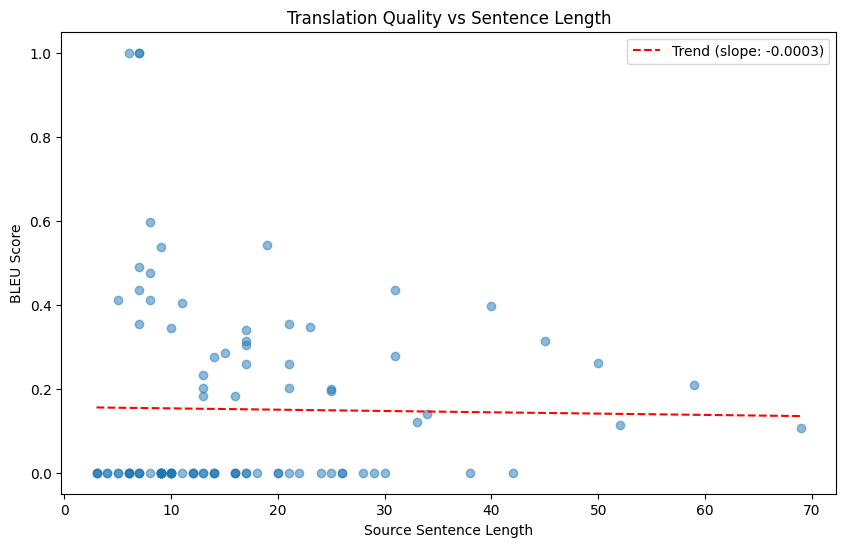

Correlation between sentence length and BLEU score: -0.017


In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(source_lengths, bleu_scores, alpha=0.5)
z = np.polyfit(source_lengths, bleu_scores, 1)
p = np.poly1d(z)
plt.plot(sorted(source_lengths), p(sorted(source_lengths)), "r--",
         label=f'Trend (slope: {z[0]:.4f})')
plt.xlabel('Source Sentence Length')
plt.ylabel('BLEU Score')
plt.title('Translation Quality vs Sentence Length')
plt.legend()
plt.show()

correlation = np.corrcoef(source_lengths, bleu_scores)[0,1]
print(f"Correlation between sentence length and BLEU score: {correlation:.3f}")

In [32]:
example_df = pd.DataFrame(translation_examples[:5])
pd.set_option('display.max_colwidth', None)
print("Sample Translations:")
print(example_df.to_string())

summary_stats = {
    'BLEU Scores': {
        'Mean': np.mean(bleu_scores),
        'Median': np.median(bleu_scores),
        'Std': np.std(bleu_scores)
    },
    'Length Analysis': {
        'Avg Source Length': np.mean(source_lengths),
        'Avg Translation Length': np.mean(translated_lengths),
        'Avg Reference Length': np.mean(target_lengths),
        'Length Correlation': np.corrcoef(source_lengths, translated_lengths)[0,1]
    }
}

summary_df = pd.DataFrame(summary_stats).round(3)

Sample Translations:
                                                                                             source                                                                                                          translation                                                                              reference
0                                                   depois , podem fazer-se e testar-se previsões .                                                                  then , you can make etest and get the predictions .                                            then , predictions can be made and tested .
1                                 forçou a parar múltiplos laboratórios que ofereciam testes brca .                                           it forced about multiple corporations countries that brcatited brrations .                  it had forced multiple labs that were offering brca testing to stop .
2       as formigas são um exemplo clássico ; as operárias trabalha